# FDW Crop Production Data Analysis - Afghanistan

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

<Axes: xlabel='year'>

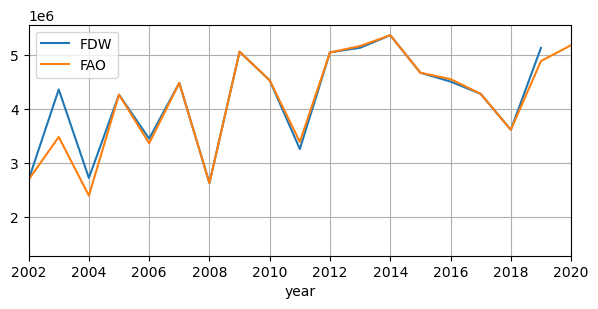

In [2]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'AF', 'Afghanistan'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
product_name, prcp_start_month, prcp_season_name = 'Wheat', 10, 'OND PRCP (mm)'
df = df[
    (df['product'].isin([product_name])) &
    (df['indicator'] == 'production')
]
df['year'] = df['harvest_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == 'Afghanistan') &
    (df['cpc2_name'] == 'Wheat') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #
data = pd.concat([data_fdw, data_fao], axis=1, keys=['FDW','FAO']).sort_index()
data.plot(xlim=[2002,2020],figsize=[7,3],grid=True)

Winter-Wheat Correlation:
           FDW      PRCP
FDW   1.000000  0.516812
PRCP  0.516812  1.000000


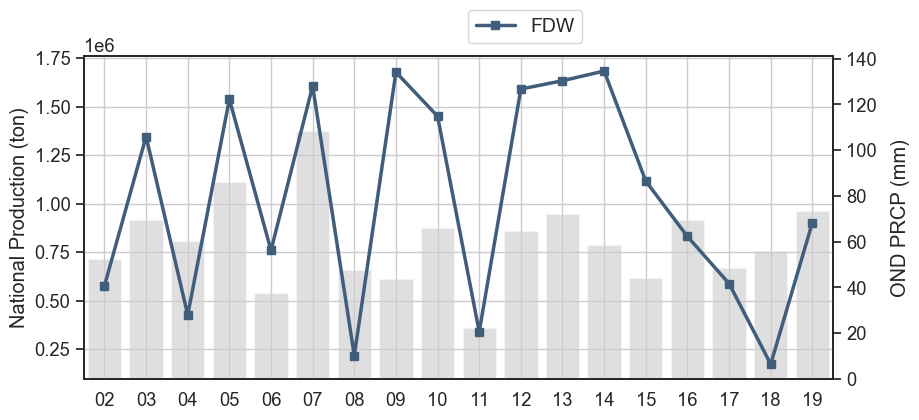

In [4]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'AF', 'Afghanistan'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# season_name, product_name, prcp_start_month, prcp_season_name = 'Deyr', 'Sorghum', 10, 'OND PRCP (mm)'
# season_name, product_name, prcp_start_month, prcp_season_name = 'Deyr', 'Maize', 10, 'OND PRCP (mm)'
# season_name, product_name, prcp_start_month, prcp_season_name = 'Gu', 'Maize', 3, 'MAM PRCP (mm)'
season_name, product_name, prcp_start_month, prcp_season_name = 'Winter', 'Wheat', 10, 'OND PRCP (mm)'
df = df[
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name])) &
    (df['indicator'] == 'production')
]
df['year'] = df['planting_year']
data = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load precipitation --------------------------------- #
prcp = pd.read_csv('../data/adm.chirps-v2.crop.AF.csv', index_col=0)[fnids]
prcp.index = pd.to_datetime(prcp.index)
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = prcp_season_name
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'{season_name}-{product_name} Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(2002,2020)
sns.set(style="white", font_scale=1.2)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(9,4))
data.index += 1
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index+1, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #

## New approach to show data points per "publication_name" and "stats"

In [6]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df.pivot_table(
    index=['source_document','publication_name'], 
    columns=['status','collection_status'],
    values='value',
    aggfunc='count'
)

status                                                                                                Collected  \
collection_status                                                                                     Published   
source_document                                    publication_name                                               
Afghanistan Agricultural Annual Report             Agricultural Annual Report 2018-19, January 2019       212.0   
Afghanistan Agricultural Annual Report (estimates) Agricultural Annual Report 2018-19, January 2019       180.0   
Afghanistan Statistical Yearbook                   Afganistan Statistical Yearbook, 2008-2009             417.0   
                                                   Afganistan Statistical Yearbook, 2009-2010             459.0   
                                                   Afganistan Statistical Yearbook, 2010-2011             453.0   
                                                   Afganistan Statistical Yearbook, 2011-2012             445.0   
                                                   Afganistan Statistical Yearbook, 2012-2013             468.0   
                                                   Afganistan Statistical Yearbook, 2013-2014             444.0   
                                                   Afganistan Statistical Yearbook, 2014-2015             418.0   
                                                   Afganistan Statistical Yearbook, 2015-2016             430.0   
                                                   Afghanistan Statistical Yearbook 2017-18, Issue...     606.0   
                                                   Afghanistan Statistical Yearbook 2018-19, Issue...     198.0   
                                                   Afghanistan Statistical Yearbook 2019, Issue: 4...      97.0   
Afghanistan Statistical Yearbook (2019-10-28)      Afghanistan Statistical Yearbook, 2011-2012              NaN   
                                                   Afghanistan Statistical Yearbook, 2012-2013              NaN   
                                                   Afghanistan Statistical Yearbook, 2013-2014              NaN   
                                                   Afghanistan Statistical Yearbook, 2014-2015              NaN   
                                                   Afghanistan Statistical Yearbook, 2015-2016              NaN   
                                                   Afghanistan Statistical Yearbook, 2016-2017              NaN   
Afghanistan Statistical Yearbook, 2016-2017        Afghanistan Statistical Yearbook, 2016-2017            186.0   
Afghanistan Statistical Yearbook, estimates                                                                12.0   

status                                                                                                           \
collection_status                                                                                     Submitted   
source_document                                    publication_name                                               
Afghanistan Agricultural Annual Report             Agricultural Annual Report 2018-19, January 2019         NaN   
Afghanistan Agricultural Annual Report (estimates) Agricultural Annual Report 2018-19, January 2019         NaN   
Afghanistan Statistical Yearbook                   Afganistan Statistical Yearbook, 2008-2009               NaN   
                                                   Afganistan Statistical Yearbook, 2009-2010               NaN   
                                                   Afganistan Statistical Yearbook, 2010-2011               NaN   
                                                   Afganistan Statistical Yearbook, 2011-2012               NaN   
                                                   Afganistan Statistical Yearbook, 2012-2013               NaN   
                                                   Afganistan Statistical Yearbook, 2013-

In [7]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df = df[(df['collection_status'] == 'Published')]

In [8]:
sub = df[
    (df['admin_1'] == 'Panjsher') &
    (df['product'] == 'Wheat Grain') &
    (df['season_name'] == 'Spring harvest') &
    (df['indicator'].isin(['Quantity Produced', 'Area Planted']))
]
sub.pivot_table(
    index=['start_date','period_date','season_year'], 
    columns=['indicator'], 
    values='value',
    aggfunc='count'
)
# sub.iloc[0]
# sub[['start_date','period_date','season_year', 'value']].sort_values('season_year')

,,indicator,Area Planted,Quantity Produced
start_date,period_date,season_year,,
2009-07-01,2009-07-31,Spring harvest 2009,1,1
2010-07-01,2010-07-31,Spring harvest 2010,1,1
2011-07-01,2011-07-31,Spring harvest 2011,1,1
2012-07-01,2012-07-31,Spring harvest 2012,1,1
2013-07-01,2013-07-31,Spring harvest 2013,1,1
2014-07-01,2014-07-31,Spring harvest 2014,1,1
2015-07-01,2015-07-31,Spring harvest 2015,1,1
2016-07-01,2016-07-31,Spring harvest 2016,1,1
2017-07-01,2017-07-31,Spring harvest 2017,1,1


## Report: Two documents indicate different values for 2018

In [8]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df = df[df['collection_status'] == 'Published']
sub = df[
    (df['admin_1'] == 'Panjsher') &
    (df['product'] == 'Wheat Grain') &
    (df['source_document'] == 'Afghanistan Statistical Yearbook')
]
sub.pivot(index=['season_year'],columns=['source_document','indicator'], values='value')

source_document     Afghanistan Statistical Yearbook                    \
indicator                               Area Planted Quantity Produced   
season_year                                                              
Autumn harvest 2017                              NaN            4.4100   
Spring harvest 2009                          5000.00        11000.0000   
Spring harvest 2010                          7000.00        21000.0000   
Spring harvest 2011                          7000.00        21000.0000   
Spring harvest 2012                          7000.00        25000.0000   
Spring harvest 2013                          7000.00        22000.0000   
Spring harvest 2014                          7100.00        23430.0000   
Spring harvest 2015                           650.00         1300.0000   
Spring harvest 2016                          6082.00        10500.0000   
Spring harvest 2017                          4410.00         8996.0000   
Spring harvest 2018                          6410.00        12820.0000   
Summer harvest 2009                          1000.00               NaN   
Summer harvest 2010                          2000.00         3000.0000   
Summer harvest 2011                          1000.00         1000.0000   
Summer harvest 2012                          2000.00         1000.0000   
Summer harvest 2013                          2000.00         1000.0000   
Summer harvest 2014                          2100.00         1827.0000   
Summer harvest 2017                             4.41            8.9964   

source_document                               
indicator               Yield Area Harvested  
season_year                                   
Autumn harvest 2017       NaN            NaN  
Spring harvest 2009  2.200000            NaN  
Spring harvest 2010  3.000000            NaN  
Spring harvest 2011  3.000000            NaN  
Spring harvest 2012  3.571429            NaN  
Spring harvest 2013  3.142857            NaN  
Spring harvest 2014  3.300000            NaN  
Spring harvest 2015  2.000000            NaN  
Spring harvest 2016  1.726406            NaN  
Spring harvest 2017  2.039909            NaN  
Spring harvest 2018  2.000000            NaN  
Summer harvest 2009       NaN            NaN  
Summer harvest 2010  1.500000            NaN  
Summer harvest 2011  1.000000            NaN  
Summer harvest 2012  0.500000            NaN  
Summer harvest 2013  0.500000            NaN  
Summer harvest 2014  0.870000            NaN  
Summer harvest 2017  2.040000            NaN

## Report: Switched values between "Quantity Produced" and "Yield"
- This occurs when "source_document" is "Afghanistan Statistical Yearbook (2019-10-28)"
- We note that this is for "submitted data".

In [9]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
source_document_list = ['Afghanistan Statistical Yearbook','Afghanistan Statistical Yearbook (2019-10-28)']
sub = df[df['source_document'].isin(source_document_list)]
sub = sub.pivot_table(index = ['fnid','season_year', 'product','indicator'], columns = ['source_document'], values='value')
sub = sub[sub.notna().sum(1) == 2]
sub

source_document                                                        Afghanistan Statistical Yearbook  \
fnid       season_year         product              indicator                                             
AF2005A101 Autumn harvest 2012 Maize Grain (Yellow) Quantity Produced                        922.000000   
                                                    Yield                                      1.640569   
           Autumn harvest 2013 Maize Grain (Yellow) Quantity Produced                       1144.000000   
                                                    Yield                                      2.200000   
                               Rice (Paddy)         Quantity Produced                        463.000000   
...                                                                                                 ...   
AF2005A134 Summer harvest 2013 Wheat Grain          Yield                                      1.000000   
           Summer harvest 2014 Wheat Grain          Quantity Produced                       1759.000000   
                                                    Yield                                      1.230070   
           Summer harvest 2017 Wheat Grain          Quantity Produced                         40.287342   
                                                    Yield                                      2.100000   

source_document                                                        Afghanistan Statistical Yearbook (2019-10-28)  
fnid       season_year         product              indicator                                                         
AF2005A101 Autumn harvest 2012 Maize Grain (Yellow) Quantity Produced                                       1.640569  
                                                    Yield                                                 922.000000  
           Autumn harvest 2013 Maize Grain (Yellow) Quantity Produced                                       2.200000  
                                                    Yield                                                1144.000000  
                               Rice (Paddy)         Quantity Produced                                       2.436842  
...                                                                                                              ...  
AF2005A134 Summer harvest 2013 Wheat Grain          Yield                                                1000.000000  
           Summer harvest 2014 Wheat Grain          Quantity Produced                                       1.230070  
                                                    Yield                                                1759.000000  
           Summer harvest 2017 Wheat Grain          Quantity Produced                                       4.200000  
                                                    Yield                                                  80.574683  

[1594 rows x 2 columns]

## Report 2: Unit has been changed in 2019

In [10]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df = df[df['collection_status'] == 'Published']
sub = df[
    (df['admin_1'] == 'Panjsher') &
    (df['product'] == 'Wheat Grain') & 
    (df['season_name'] == 'Spring harvest') & 
    (df['indicator'] == 'Quantity Produced')
]
sub[['fnid','admin_1','season_year','value','source_document','publication_name']].sort_values('season_year')

,fnid,admin_1,season_year,value,source_document,publication_name
1532,AF2005A108,Panjsher,Spring harvest 2009,11000.000000,Afghanistan Statistical Yearbook,"Afganistan Statistical Yearbook, 2008-2009"
1527,AF2005A108,Panjsher,Spring harvest 2010,21000.000000,Afghanistan Statistical Yearbook,"Afganistan Statistical Yearbook, 2009-2010"
1523,AF2005A108,Panjsher,Spring harvest 2011,21000.000000,Afghanistan Statistical Yearbook,"Afganistan Statistical Yearbook, 2010-2011"
1519,AF2005A108,Panjsher,Spring harvest 2012,25000.000000,Afghanistan Statistical Yearbook,"Afganistan Statistical Yearbook, 2011-2012"
1516,AF2005A108,Panjsher,Spring harvest 2013,22000.000000,Afghanistan Statistical Yearbook,"Afganistan Statistical Yearbook, 2012-2013"
1512,AF2005A108,Panjsher,Spring harvest 2014,23430.000000,Afghanistan Statistical Yearbook,"Afganistan Statistical Yearbook, 2013-2014"
1507,AF2005A108,Panjsher,Spring harvest 2015,1300.000000,Afghanistan Statistical Yearbook,"Afganistan Statistical Yearbook, 2014-2015"
1504,AF2005A108,Panjsher,Spring harvest 2016,10500.000000,Afghanistan Statistical Yearbook,"Afganistan Statistical Yearbook, 2015-2016"
4602,AF2017A108,Panjsher,Spring harvest 2017,8996.000000,Afghanistan Statistical Yearbook,"Afghanistan Statistical Yearbook 2017-18, Issu..."
92,AF2005A108,Panjsher,Spring harvest 2018,12.820000,Afghanistan Agricultural Annual Report,"Agricultural Annual Report 2018-19, January 2019"


## Report: Duplicate values between "publication_name"
- We note that "Autumn harvest 2017" data is invalid (mismatched values and indicators) as well 
- We often find below selections have equal values
  - "Autumn harvest 2017" & "Wheat Grain" & "Quantity Produced"
  - "Summer harvest 2017" & "Wheat Grain" & "Area Planted"

In [11]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
rows = ['fnid','crop_production_system','season_year', 'product','indicator']
sub = df[df['collection_status'] == 'Published']
sub = sub[sub[rows].duplicated(keep=False)]
sub.pivot_table(index = ['fnid','season_year', 'product','indicator'], columns = ['source_document', 'publication_name'], values='value')

source_document                                                                              Afghanistan Statistical Yearbook  \
publication_name                                             Afghanistan Statistical Yearbook 2017-18, Issue: 39, August 2018   
fnid       season_year         product     indicator                                                                            
AF2005A101 Autumn harvest 2017 Wheat Grain Quantity Produced                                           6.436000                 
           Summer harvest 2017 Wheat Grain Area Planted                                                6.436000                 
                                           Quantity Produced                                          16.090000                 
                                           Yield                                                       2.500000                 
AF2005A102 Autumn harvest 2017 Wheat Grain Area Planted                                                0.102000                 
...                                                                                                         ...                 
AF2005A133 Summer harvest 2017 Wheat Grain Yield                                                       2.700000                 
AF2005A134 Autumn harvest 2017 Wheat Grain Quantity Produced                                          19.184448                 
           Summer harvest 2017 Wheat Grain Area Planted                                               19.184448                 
                                           Quantity Produced                                          40.287342                 
                                           Yield                                                       2.100000                 

source_document                                              Afghanistan Statistical Yearbook, 2016-2017  
publication_name                                             Afghanistan Statistical Yearbook, 2016-2017  
fnid       season_year         product     indicator                                                      
AF2005A101 Autumn harvest 2017 Wheat Grain Quantity Produced                                    6.436000  
           Summer harvest 2017 Wheat Grain Area Planted                                         6.436000  
                                           Quantity Produced                                   16.090000  
                                           Yield                                                2.500000  
AF2005A102 Autumn harvest 2017 Wheat Grain Area Planted                                         0.102000  
...                                                                                                  ...  
AF2005A133 Summer harvest 2017 Wheat Grain Yield                                                2.700000  
AF2005A134 Autumn harvest 2017 Wheat Grain Quantity Produced                                   19.184448  
           Summer harvest 2017 Wheat Grain Area Planted                                        19.184448  
                                           Quantity Produced                                   40.287342  
                                           Yield                                                2.100000  

[186 rows x 2 columns]

It turns out when "publication_name" is "Afghanistan Statistical Yearbook 2017-18, Issue: 39, August 2018", the data includes 

In [12]:
sub = df[
    (df['admin_1'] == 'Panjsher') &
    (df['product'] == 'Wheat Grain') & 
    (df['season_name'] == 'Spring harvest')
]
sub.pivot_table(index=['admin_1','season_year'],columns=['source_document','indicator'],values='value')

source_document              Afghanistan Agricultural Annual Report  \
indicator                                              Area Planted   
admin_1  season_year                                                  
Panjsher Spring harvest 2009                                    NaN   
         Spring harvest 2010                                    NaN   
         Spring harvest 2011                                    NaN   
         Spring harvest 2012                                    NaN   
         Spring harvest 2013                                    NaN   
         Spring harvest 2014                                    NaN   
         Spring harvest 2015                                    NaN   
         Spring harvest 2016                                    NaN   
         Spring harvest 2017                                    NaN   
         Spring harvest 2018                                   6.41   
         Spring harvest 2019                                    NaN   

source_document                                       \
indicator                    Quantity Produced Yield   
admin_1  season_year                                   
Panjsher Spring harvest 2009               NaN   NaN   
         Spring harvest 2010               NaN   NaN   
         Spring harvest 2011               NaN   NaN   
         Spring harvest 2012               NaN   NaN   
         Spring harvest 2013               NaN   NaN   
         Spring harvest 2014               NaN   NaN   
         Spring harvest 2015               NaN   NaN   
         Spring harvest 2016               NaN   NaN   
         Spring harvest 2017               NaN   NaN   
         Spring harvest 2018             12.82   2.0   
         Spring harvest 2019               NaN   NaN   

source_document              Afghanistan Agricultural Annual Report (estimates)  \
indicator                                                          Area Planted   
admin_1  season_year                                                              
Panjsher Spring harvest 2009                                                NaN   
         Spring harvest 2010                                                NaN   
         Spring harvest 2011                                                NaN   
         Spring harvest 2012                                                NaN   
         Spring harvest 2013                                                NaN   
         Spring harvest 2014                                                NaN   
         Spring harvest 2015                                                NaN   
         Spring harvest 2016                                                NaN   
         Spring harvest 2017                                                NaN   
         Spring harvest 2018                                                NaN   
         Spring harvest 2019                                              6.615   

source_document                                           \
indicator                    Quantity Produced     Yield   
admin_1  season_year                                       
Panjsher Spring harvest 2009               NaN       NaN   
         Spring harvest 2010               NaN       NaN   
         Spring harvest 2011               NaN       NaN   
         Spring harvest 2012               NaN       NaN   
         Spring harvest 2013               NaN       NaN   
         Spring harvest 2014               NaN       NaN   
         Spring harvest 2015               NaN       NaN   
         Spring harvest 2016               NaN       NaN   
         Spring harvest 2017               NaN       NaN   
         Spring harvest 2018               NaN       NaN   
         Spring harvest 2019         14.937877  2.258182   

source_document              Afghanistan Statistical Yearbook  \
indicator                                        Area Planted   
admin_1  season_year                                            
Panjsher Spring harve

## Report 3: Wrong Autumn harvest 2017 data

In [14]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df = df[df['collection_status'] == 'Published']
rows = ['fnid','crop_production_system','season_year', 'product','indicator']
sub = df[df['collection_status'] == 'Published']
sub = sub[sub[rows].duplicated(keep=False)]
sub.pivot_table(index = ['fnid','season_year', 'product','indicator'], columns = ['source_document', 'publication_name'], values='value')

source_document                                                                              Afghanistan Statistical Yearbook  \
publication_name                                             Afghanistan Statistical Yearbook 2017-18, Issue: 39, August 2018   
fnid       season_year         product     indicator                                                                            
AF2005A101 Autumn harvest 2017 Wheat Grain Quantity Produced                                           6.436000                 
           Summer harvest 2017 Wheat Grain Area Planted                                                6.436000                 
                                           Quantity Produced                                          16.090000                 
                                           Yield                                                       2.500000                 
AF2005A102 Autumn harvest 2017 Wheat Grain Area Planted                                                0.102000                 
...                                                                                                         ...                 
AF2005A133 Summer harvest 2017 Wheat Grain Yield                                                       2.700000                 
AF2005A134 Autumn harvest 2017 Wheat Grain Quantity Produced                                          19.184448                 
           Summer harvest 2017 Wheat Grain Area Planted                                               19.184448                 
                                           Quantity Produced                                          40.287342                 
                                           Yield                                                       2.100000                 

source_document                                              Afghanistan Statistical Yearbook, 2016-2017  
publication_name                                             Afghanistan Statistical Yearbook, 2016-2017  
fnid       season_year         product     indicator                                                      
AF2005A101 Autumn harvest 2017 Wheat Grain Quantity Produced                                    6.436000  
           Summer harvest 2017 Wheat Grain Area Planted                                         6.436000  
                                           Quantity Produced                                   16.090000  
                                           Yield                                                2.500000  
AF2005A102 Autumn harvest 2017 Wheat Grain Area Planted                                         0.102000  
...                                                                                                  ...  
AF2005A133 Summer harvest 2017 Wheat Grain Yield                                                2.700000  
AF2005A134 Autumn harvest 2017 Wheat Grain Quantity Produced                                   19.184448  
           Summer harvest 2017 Wheat Grain Area Planted                                        19.184448  
                                           Quantity Produced                                   40.287342  
                                           Yield                                                2.100000  

[186 rows x 2 columns]

## Report 3: No shapefile "AF2018A1"

In [ ]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df['level'] = df['fnid'].apply(lambda x: x[:8])
sub = df[['admin_1','fnid','level']].drop_duplicates()
sub.pivot_table(index='admin_1', columns='level', values='fnid',aggfunc=lambda x: ' '.join(x)).tail(20)

level,AF2005A1,AF2017A1,AF2018A1
admin_1,,,
Khost,AF2005A126,AF2017A114,AF2018A114
Kunar,AF2005A113,AF2017A115,AF2018A115
Kunduz,AF2005A117,AF2017A119,AF2018A119
Laghman,AF2005A107,AF2017A107,AF2018A107
Logar,AF2005A105,AF2017A105,AF2018A105
Maidan Wardak,NaN,NaN,AF2018A104
Nangarhar,AF2005A106,AF2017A106,AF2018A106
Nimroz,AF2005A134,AF2017A134,AF2018A134
Nuristan,AF2005A114,AF2017A116,AF2018A116


In [ ]:
{'Hirat':'Herat','Maidan Wardak':'Wardak', 'Sar-e-Pul':'Sar-e-Pul'}